In [38]:
import pandas as pd
import cv2
from pylab import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MultiLabelBinarizer, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib
from sklearn.decomposition import RandomizedPCA

%matplotlib inline

In [3]:
df_train = pd.read_csv("../../data/CrowdFlowerImageSentiment/sentiment-train.csv")
df_test = pd.read_csv("../../data/CrowdFlowerImageSentiment/sentiment-test.csv")

In [8]:
image_paths_train = list(df_train["image_paths"])
image_paths_test = list(df_test["image_paths"])

## Sample image

More importantly, check if images are in correct directories.

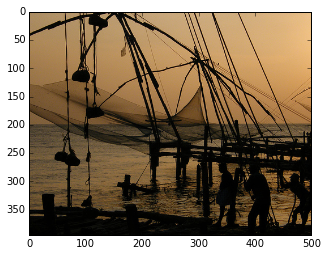

In [6]:
img = cv2.imread(image_paths_train[0])
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

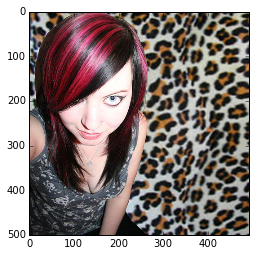

In [9]:
img = cv2.imread(image_paths_test[0])
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Setup Trained Network

In [17]:
from util.skicaffe import SkiCaffe

In [18]:
caffe_root = '/usr/local/src/caffe/caffe-master/'
model_prototxt = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_trained = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
DLmodel = SkiCaffe(caffe_root = caffe_root,model_prototxt_path = model_prototxt, model_trained_path = model_trained, layer_name = 'fc8')
DLmodel.fit()
print 'Number of layers:', len(DLmodel.layer_sizes)
DLmodel.layer_sizes

caffe imported successfully
Number of layers: 15


[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [42]:
X_train = image_paths_train
y_train = label_binarize(array(df_train.which_of_these_sentiment_scores_does_the_above_image_fit_into_best), 
                       classes = [0,1,2,3,4])
print "num examples from X", len(X_train)
print "num examples and labels from y", y_train.shape

num examples from X 9434
num examples and labels from y (9434, 5)


In [27]:
layers = [l[0] for l in DLmodel.layer_sizes]
layers.remove('data')
layers = ['norm1', 'norm2', 'conv3', 'conv4', 'pool5', 'fc6', 'fc7', 'fc8', 'prob']
layers = ['prob', 'fc8', 'fc7', 'fc6', 'pool5', 'conv4', 'conv3', 'norm2', 'norm1']

In [28]:
best_params = []
best_scores = []
layer_names = []

In [43]:
for layer in layers[:2]:
    print '********************************************************************'
    print 'working on layer', layer
    print '********************************************************************'
    #feature_pipe = Pipeline([('ANN', SkiCaffe(caffe_root = caffe_root,model_prototxt_path = model_prototxt, model_trained_path = model_trained, layer_name = layer))])
    feature_pipe = Pipeline([('ANN', SkiCaffe(caffe_root = caffe_root,model_prototxt_path = model_prototxt, model_trained_path = model_trained, layer_name = layer)),
                            ('pca', RandomizedPCA(n_components=1000, whiten = False))])
    feaures = feature_pipe.fit_transform(X_train[:1100])
    print '********************************************************************'
    print 'feaures shape is', feaures.shape
    print 'classifying', layer
    print '********************************************************************'

    lr_pipe = Pipeline([('OVClr', OneVsRestClassifier(LogisticRegression()))])
    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    param_grid = [{'OVClr__estimator__C': param_range[:3]}]
    gs = GridSearchCV(estimator = lr_pipe, param_grid = param_grid, scoring = 'average_precision', cv = 5, n_jobs=-1)
    gs.fit(feaures, y_train[:1100,:])
    layer_names.append(layer)
    best_params.append(gs.best_params_)
    best_scores.append(gs.best_score_)
    temp_df = pd.DataFrame({'layer.name': layer_names, 'best_scores': best_scores, 'best_params': best_params})
    temp_df.to_pickle("../../results/CrowdFlower-LR" + layer + ".pkl")

********************************************************************
working on layer prob
********************************************************************
caffe imported successfully
********************************************************************
feaures shape is (1100, 1000)
classifying prob
********************************************************************
********************************************************************
working on layer fc8
********************************************************************
caffe imported successfully
********************************************************************
feaures shape is (1100, 1000)
classifying fc8
********************************************************************


/home/myazdani/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/myazdani/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/myazdani/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/myazdani/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/myazdani/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/home/myazdani/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/myazdani/anaconda/lib/python2.7/site-pac

In [47]:
results_df = pd.DataFrame({'layer.name': layer_names, 'best_scores': best_scores, 'best_params': best_params})
results_df.head()

results_df.to_pickle("../../results/CrowdFlower-LR.pkl")